In [1]:
## とりあえず必要そうなもの入れる
!pip install janome
!pip install gensim
!pip install lightgbm
## 楽したいのでoptuna
!pip install optuna
!pip install pymysql

     |████████████████████████████████| 19.7MB 8.9MB/s 
     |████████████████████████████████| 296kB 5.5MB/s 
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 1.1MB 6.1MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 112kB 16.1MB/s 
     |████████████████████████████████| 143kB 16.0MB/s 
     |████████████████████████████████| 481kB 12.6MB/s 
  Created wheel for alembic: filename=alembic-1.5.4-py2.py3-none-any.whl size=156314 sha256=d6cb2fc854134a805ec219567f2e93ba4afbd15d07777f38ccf723bd67ce4066
  Stored in directory: /root/.cache/pip/wheels/fd/2d/ec/5a1b1e2363ed68392d292d215facf588d5448198edd8078bc1
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=ce49e15f8cde3386f27001ff4792a478a25d7d421cec1a99347e20febd3f8278
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: 

In [2]:
import numpy as np
import pandas as pd

## sklearn関連
## サポートベクターマシンがモダンな回帰ができると聞き、検証してみたけど、特に精度に変化なし
#from sklearn.sm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## lightGBM
import lightgbm as lgb

## たぶん形態素解析してみるよ
from janome.tokenizer import Tokenizer
#from gensim.models import word2vec

In [3]:
import ast
import collections
import matplotlib.pyplot as plt
import math
import re
import janome
import warnings
import json
import pymysql

In [6]:
def read_table(columns, table_type):

    if table_type == "train":
        table_names = ['train_framework_skillset', 'train_language_skillset', 'train_master_job_board', 'train_working_conditions']
    else:
        table_names = ['test_framework_skillset', 'test_language_skillset', 'test_master_job_board', 'test_working_conditions']

    sql =f'''
        SELECT
            t1.{columns[0]},
            t1.{columns[1]},
            t2.{columns[2]},
            t3.{columns[3]},
            t3.{columns[4]},
            t4.{columns[5]}
        FROM {table_names[0]} as t1
        INNER JOIN
            {table_names[1]} as t2
        ON
            t1.{columns[0]} = t2.{columns[0]}
        INNER JOIN
            {table_names[2]} as t3
        ON
            t3.{columns[0]} = t2.{columns[0]}
        INNER JOIN
            {table_names[3]} as t4
        ON
            t4.{columns[0]} = t3.{columns[0]}
    '''

    connection = pymysql.connect(
    host='datamix-school-material.csbsmnjyxb52.ap-northeast-1.rds.amazonaws.com',
    user='user1',
    passwd='user1',
    db='advance_job_board_data',
    charset='utf8')

    try:
        with connection.cursor() as cursor:
            cursor.execute(sql)
            rows = cursor.fetchall()

            new_result = [one for one in rows]
            dataframe = pd.DataFrame(new_result)
            dataframe.columns = columns

    finally:
        connection.close()
    return dataframe

In [7]:
columns = ['company_id', 'framework_skillset', 'language_skillset', 'position', 'job_board_info', 'working_conditions']

joined_tblmaster_df = read_table(columns, "train")

In [8]:
joined_tblmaster_df.tail()

,company_id,framework_skillset,language_skillset,position,job_board_info,working_conditions
1198,C1891d63,Android SDK/ iOS SDK,Java/ Objective-C,ネイティブエンジニア（PL）,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...
1199,C1892d63,iOS SDK/ Unity/ cocos2d,Objective-C/ Swift,iOSアプリエンジニア,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...
1200,C1893d63,Unity,Java/ C/ C++/ C＃/ PHP/ Ruby/ Perl,サーバーサイドエンジニア（PL）,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...
1201,C1894d63,Android SDK/ Unity/ cocos2d,Java,Androidアプリエンジニア,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...
1202,C1895c03,,Java,システムエンジニア,"{'employee_num': 5.0, 'location': '東京都渋谷区', 's...",服装自由/ イヤホンOK/ 女性エンジニアが在籍/ 若手歓迎/ オンライン面談可


In [9]:
## index貼る
train_df = joined_tblmaster_df.set_index('company_id', inplace = False)

In [10]:
train_df.head()

,framework_skillset,language_skillset,position,job_board_info,working_conditions
company_id,,,,,
Cd346dca,CakePHP/ jQuery,PHP/ Python3/ JavaScript,サーバサイドエンジニア（開発チーム リーダー候補）,"{'employee_num': 26.0, 'location': '東京都千代田区', ...",服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 残業３０H以内/ フリードリンク/...
C713a7cd,,Java/ C/ VB/ JavaScript/ HTML+CSS,プログラマ,"{'employee_num': 17.0, 'location': '東京都立川市', '...",残業３０H以内/ 日本語がネイティブレベルでなくても可
C1000ca5,CodeIgniter/ Ruby on Rails,Go言語/ PHP/ Ruby/ HTML5+CSS3/ HTML+CSS,サーバーサイドエンジニア,"{'employee_num': 76.0, 'location': '東京都目黒区', '...",服装自由/ イヤホンOK/ ノートPC＋モニタ別途支給/ 裁量労働/ フリードリンク/ 若手...
C10010c0,FuelPHP/ jQuery/ Vue.js,PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL,バックエンドエンジニア（大阪）,"{'employee_num': 53.0, 'location': '大阪府大阪市', '...",服装自由/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋モニタ別途支給/...
C94ef74d,CodeIgniter/ Smarty/ Ruby on Rails/ jQuery,PHP/ Ruby/ JavaScript/ HTML5+CSS3/ SQL,CTO候補,"{'employee_num': 30.0, 'location': '東京都新宿区', '...",服装自由/ イヤホンOK/ フリーソフト利用可/ ノートPC＋モニタ別途支給/ 1920x1...


In [11]:
train_df['employee_num'] = train_df['job_board_info'].apply(lambda x: ast.literal_eval(x)['employee_num'])
train_df['location'] = train_df['job_board_info'].apply(lambda x: ast.literal_eval(x)['location'])
train_df['salary_min'] = train_df['job_board_info'].apply(lambda x: ast.literal_eval(x)['salary_min'])

In [12]:
# パースされたか確認
train_df['salary_min'].describe()

count    1203.000000
mean      417.538653
std        89.897691
min       220.000000
25%       358.000000
50%       400.000000
75%       450.000000
max       800.000000
Name: salary_min, dtype: float64

In [13]:
## これで一括リプレースできそうだったけど、pandas力不足のため諦め、seriesでappendでもよかったかも
'''
df = {}
for idx,value in enumerate(position_dict):
  print(idx,value, position_dict[value])
  df = train_df.replace(f'(.*)k(.*)', r"{v}".format(v=v), regex=True)
'''

'\ndf = {}\nfor idx,value in enumerate(position_dict):\n  print(idx,value, position_dict[value])\n  df = train_df.replace(f\'(.*)k(.*)\', r"{v}".format(v=v), regex=True)\n'

In [14]:
train_df.tail()

,framework_skillset,language_skillset,position,job_board_info,working_conditions,employee_num,location,salary_min
company_id,,,,,,,,
C1891d63,Android SDK/ iOS SDK,Java/ Objective-C,ネイティブエンジニア（PL）,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...,15.0,東京都港区,500.0
C1892d63,iOS SDK/ Unity/ cocos2d,Objective-C/ Swift,iOSアプリエンジニア,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...,15.0,東京都港区,300.0
C1893d63,Unity,Java/ C/ C++/ C＃/ PHP/ Ruby/ Perl,サーバーサイドエンジニア（PL）,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...,15.0,東京都港区,500.0
C1894d63,Android SDK/ Unity/ cocos2d,Java,Androidアプリエンジニア,"{'employee_num': 15.0, 'location': '東京都港区', 's...",服装自由/ イヤホンOK/ 社長が現役or元エンジニア/ フリーソフト利用可/ ノートPC＋...,15.0,東京都港区,300.0
C1895c03,,Java,システムエンジニア,"{'employee_num': 5.0, 'location': '東京都渋谷区', 's...",服装自由/ イヤホンOK/ 女性エンジニアが在籍/ 若手歓迎/ オンライン面談可,5.0,東京都渋谷区,600.0


In [15]:
# 特徴量生成モジュール
!git clone https://github.com/Ryoayasora85/datmx.git

Cloning into 'datmx'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [16]:
from datmx.gen_OneHotEnc import GDF

In [17]:
exclude_cols = ['employee_num', 'AI','position', 'job_board_info', 'language_skillset','framework_skillset', 'working_conditions','location','salary_min','position_tokenized','海外']
target_col = 'salary_min'

gdf=GDF()
gdf.gen_position(train_df)
gdf.gen_locale(train_df)
gdf.gen_language(train_df)
feature_cols = gdf.exclude_clm(train_df, exclude_cols)

PHP/ Python3/ JavaScript
Java/ C/ VB/ JavaScript/ HTML+CSS
Go言語/ PHP/ Ruby/ HTML5+CSS3/ HTML+CSS
PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL
PHP/ Ruby/ JavaScript/ HTML5+CSS3/ SQL
PHP/ C++/ C＃/ JavaScript/ HTML+CSS
Scala/ Swift/ JavaScript/ HTML+CSS/ Kotlin
Python3/ C＃/ Ruby/ R言語
Python3
Python3
PHP/ Python2/ Python3/ VB/ JavaScript/ HTML+CSS
Java/ Python3/ JavaScript/ Kotlin
PHP/ Python2/ Python3/ VB/ JavaScript/ HTML+CSS
Java/ PHP/ SQL/ Bash
Ruby/ JavaScript
Ruby/ JavaScript
Java/ C＃/ PHP/ JavaScript/ HTML5+CSS3
Python3/ Go言語/ TypeScript
PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL
PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS/ SQL
Java/ PHP/ SQL
JavaScript/ HTML5+CSS3/ HTML+CSS/ TypeScript
PHP
Python3/ Java/ C/ Ruby/ R言語
Go言語/ JavaScript/ Ruby/ Python3
PHP/ Scala/ Go言語
TypeScript
Go言語/ PHP/ Scala/ Node.js
PHP/ JavaScript/ HTML5+CSS3/ HTML+CSS
Python3/ C++/ Objective-C/ JavaScript/ SQL
SQL
Go言語/ PHP/ Scala
PHP/ C/ HTML5+CSS3/ HTML+CSS
Java/ PHP/ Objective-C/ Swift/ JavaScript
C++/ Java/ Ruby/ P

In [18]:
train_df[feature_cols].head()

,エンジニア,マネージャ,コーダー,プログラマー,プロダクトオーナー,CTO,スクラムマスタ,データサイエンティスト,アーキテクト,インフラ,SP,北海道,東北,関東,中部,近畿,中国,四国,九州,沖縄県,FrontEnd,BackEnd,ServerSide,Build-in,android,scala,R言語,ios,others
company_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cd346dca,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C713a7cd,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1000ca5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C10010c0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C94ef74d,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# 欠損値確認
train_df[feature_cols].isnull().sum()

エンジニア          0
マネージャ          0
コーダー           0
プログラマー         0
プロダクトオーナー      0
CTO            0
スクラムマスタ        0
データサイエンティスト    0
アーキテクト         0
インフラ           0
SP             0
北海道            0
東北             0
関東             0
中部             0
近畿             0
中国             0
四国             0
九州             0
沖縄県            0
FrontEnd       0
BackEnd        0
ServerSide     0
Build-in       0
android        0
scala          0
R言語            0
ios            0
others         0
dtype: int64

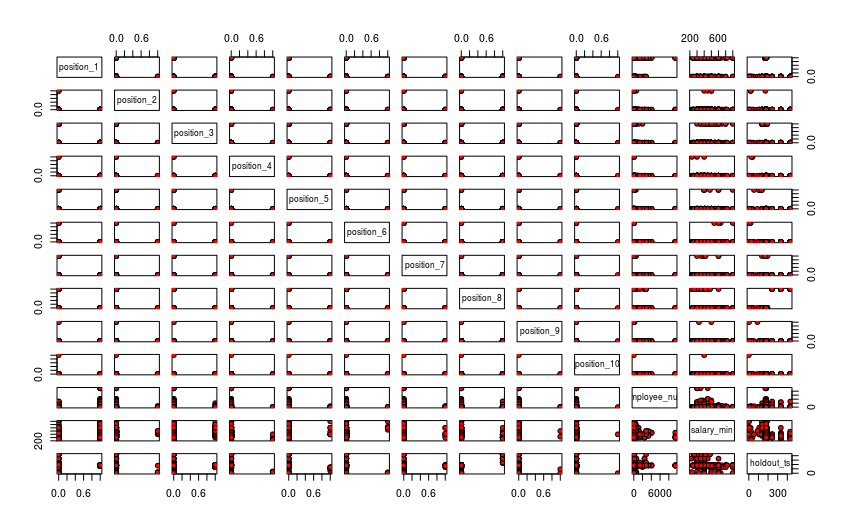

'\n> train <- read.csv("holdout_ts_employee_num01.csv", header=TRUE, fileEncoding="CP932")\n> \n> round(cor(train),4)\n             position_1 position_2 position_3 position_4 position_5 position_6 position_7 position_8\nposition_1       1.0000    -0.1653    -0.5958    -0.1431    -0.2341    -0.1849    -0.2189    -0.6020\nposition_2      -0.1653     1.0000    -0.0120    -0.0029    -0.0047    -0.0037    -0.0044    -0.0121\nposition_3      -0.5958    -0.0120     1.0000    -0.0104    -0.0170    -0.0134    -0.0159    -0.0436\nposition_4      -0.1431    -0.0029    -0.0104     1.0000    -0.0041    -0.0032    -0.0038    -0.0105\nposition_5      -0.2341    -0.0047    -0.0170    -0.0041     1.0000    -0.0053    -0.0062    -0.0171\nposition_6      -0.1849    -0.0037    -0.0134    -0.0032    -0.0053     1.0000    -0.0049    -0.0135\nposition_7      -0.2189    -0.0044    -0.0159    -0.0038    -0.0062    -0.0049     1.0000    -0.0160\nposition_8      -0.6020    -0.0121    -0.0436    -0.0105    -0.01

In [22]:
from IPython.display import Image,display_png
display_png(Image('./datmx/Rplot02.png'))

## seabornとかpltが使い方よくわかってないので、Rで相関みてみました
'''
> train <- read.csv("holdout_ts_employee_num01.csv", header=TRUE, fileEncoding="CP932")
> 
> round(cor(train),4)
             position_1 position_2 position_3 position_4 position_5 position_6 position_7 position_8
position_1       1.0000    -0.1653    -0.5958    -0.1431    -0.2341    -0.1849    -0.2189    -0.6020
position_2      -0.1653     1.0000    -0.0120    -0.0029    -0.0047    -0.0037    -0.0044    -0.0121
position_3      -0.5958    -0.0120     1.0000    -0.0104    -0.0170    -0.0134    -0.0159    -0.0436
position_4      -0.1431    -0.0029    -0.0104     1.0000    -0.0041    -0.0032    -0.0038    -0.0105
position_5      -0.2341    -0.0047    -0.0170    -0.0041     1.0000    -0.0053    -0.0062    -0.0171
position_6      -0.1849    -0.0037    -0.0134    -0.0032    -0.0053     1.0000    -0.0049    -0.0135
position_7      -0.2189    -0.0044    -0.0159    -0.0038    -0.0062    -0.0049     1.0000    -0.0160
position_8      -0.6020    -0.0121    -0.0436    -0.0105    -0.0171    -0.0135    -0.0160     1.0000
position_9      -0.1168    -0.0023    -0.0085    -0.0020    -0.0033    -0.0026    -0.0031    -0.0085
position_10     -0.0825    -0.0017    -0.0060    -0.0014    -0.0024    -0.0019    -0.0022    -0.0060
employee_num    -0.0196     0.0000    -0.0029    -0.0092    -0.0082    -0.0146     0.0020     0.0447
salary_min      -0.0701     0.0289     0.2081    -0.0598     0.0842     0.1557     0.0192    -0.1809
holdout_ts      -0.3095    -0.1654    -0.0787    -0.1713    -0.1331    -0.2600    -0.0246     0.8353
             position_9 position_10 employee_num salary_min holdout_ts
position_1      -0.1168     -0.0825      -0.0196    -0.0701    -0.3095
position_2      -0.0023     -0.0017       0.0000     0.0289    -0.1654
position_3      -0.0085     -0.0060      -0.0029     0.2081    -0.0787
position_4      -0.0020     -0.0014      -0.0092    -0.0598    -0.1713
position_5      -0.0033     -0.0024      -0.0082     0.0842    -0.1331
position_6      -0.0026     -0.0019      -0.0146     0.1557    -0.2600
position_7      -0.0031     -0.0022       0.0020     0.0192    -0.0246
position_8      -0.0085     -0.0060       0.0447    -0.1809     0.8353
position_9       1.0000     -0.0012      -0.0052    -0.0016    -0.1280
position_10     -0.0012      1.0000      -0.0071    -0.0056    -0.1211
employee_num    -0.0052     -0.0071       1.0000    -0.0559     0.0234
salary_min      -0.0016     -0.0056      -0.0559     1.0000    -0.2032
holdout_ts      -0.1280     -0.1211       0.0234    -0.2032     1.0000

position_3, position_6に弱い相関あり 

￼￼￼> pairs(train, pch=21, bg='red')
'''

In [23]:
'''
> train_reg <- lm(salary_min~position_3+position_6, train)
> 
> summary(train_reg)

Call:
lm(formula = salary_min ~ position_3 + position_6, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-207.28  -62.68  -12.68   37.32  387.32 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  412.676      2.551 161.764  < 2e-16 ***
position_3    94.604     12.513   7.560 7.94e-14 ***
position_6   221.324     38.824   5.701 1.50e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 86.62 on 1205 degrees of freedom
Multiple R-squared:  0.06843,	Adjusted R-squared:  0.06689 
F-statistic: 44.26 on 2 and 1205 DF,  p-value: < 2.2e-16
'''
## 微妙すぎました

'\n> train_reg <- lm(salary_min~position_3+position_6, train)\n> \n> summary(train_reg)\n\nCall:\nlm(formula = salary_min ~ position_3 + position_6, data = train)\n\nResiduals:\n    Min      1Q  Median      3Q     Max \n-207.28  -62.68  -12.68   37.32  387.32 \n\nCoefficients:\n            Estimate Std. Error t value Pr(>|t|)    \n(Intercept)  412.676      2.551 161.764  < 2e-16 ***\nposition_3    94.604     12.513   7.560 7.94e-14 ***\nposition_6   221.324     38.824   5.701 1.50e-08 ***\n---\nSignif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1\n\nResidual standard error: 86.62 on 1205 degrees of freedom\nMultiple R-squared:  0.06843,\tAdjusted R-squared:  0.06689 \nF-statistic: 44.26 on 2 and 1205 DF,  p-value: < 2.2e-16\n'

In [25]:
X = train_df[feature_cols]
y = train_df[target_col]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=114514)
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=114514)

In [26]:
import optuna

def optunas_obj(trial):
    # ハイパーパラメータ自動検索
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),}

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train,eval_set=(X_val,y_val),early_stopping_rounds=100,verbose=False)

    y_pred = model.predict(X_test)

    # validデータ評価
    score = model.score(X_val, y_val)
    
    return score


In [27]:
from sklearn.metrics import r2_score

In [ ]:
# optunaによる最適化呼び出し
opt = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
opt.optimize(optunas_obj, n_trials=500)

trial = opt.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 0
    
# 検索パラメータで学習  
model_o = lgb.LGBMRegressor(**params_best)
model_o.fit(X_train, y_train, eval_set=(X_val,y_val),early_stopping_rounds=100,verbose=False)    

y_trainval_pred = model_o.predict(X_trainval)
y_test_pred_result = model_o.predict(X_test)

r2_trainval = r2_score(y_trainval, y_trainval_pred)
r2_test = r2_score(y_test, y_test_pred_result)

# テストデータで評価
print("r2_train:{0:.4}".format(r2_trainval))
print("r2_test:{0:.4}".format(r2_test))

[I 2021-02-13 11:15:07,369] A new study created in memory with name: no-name-133a4eab-db92-446f-8e33-9772f4be79ee
[I 2021-02-13 11:15:07,422] Trial 0 finished with value: 0.16280716136440043 and parameters: {'num_leaves': 174, 'min_child_samples': 49}. Best is trial 0 with value: 0.16280716136440043.
[I 2021-02-13 11:15:07,463] Trial 1 finished with value: 0.17162903209014913 and parameters: {'num_leaves': 119, 'min_child_samples': 66}. Best is trial 1 with value: 0.17162903209014913.
[I 2021-02-13 11:15:07,502] Trial 2 finished with value: 0.17107730523252698 and parameters: {'num_leaves': 69, 'min_child_samples': 69}. Best is trial 1 with value: 0.17162903209014913.
[I 2021-02-13 11:15:07,581] Trial 3 finished with value: 0.16848597040438373 and parameters: {'num_leaves': 105, 'min_child_samples': 11}. Best is trial 1 with value: 0.17162903209014913.
[I 2021-02-13 11:15:07,638] Trial 4 finished with value: 0.16310140511277468 and parameters: {'num_leaves': 213, 'min_child_samples': 2

r2_train:0.2206
r2_test:0.1838


In [ ]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test_pred_result, y_test)))

RMSE:  74.95199519550025


In [ ]:
# history
hist_df = study.trials_dataframe()
hist_df.to_csv("result_svr.csv")

In [ ]:
joined_tbl_test_df = read_table(sql, columns, "test")
## index貼る
train_df = joined_tbl_test_df.set_index('company_id', inplace = False)
train_df.shape

(516, 6)

In [ ]:
train_df['employee_num'] = train_df['job_board_info'].apply(lambda x: ast.literal_eval(x.replace('nan', '0'))['employee_num'])
train_df['location'] = train_df['job_board_info'].apply(lambda x: ast.literal_eval(x.replace('nan', '0'))['location'])

In [ ]:
gdf.gen_test_position(train_df)
gdf.gen_test_locale(train_df)
gdf.gen_test_language(train_df)

In [ ]:
X_test_entity = train_df[feature_cols]
y_test_result = model_o.predict(X_test_entity)

In [ ]:
y_test_result

array([422.36352012, 397.72780274, 413.48313605, 416.52096181,
       422.51810326, 357.38594293, 389.90981008, 386.04589266,
       416.61415128, 386.04589266, 418.47575374, 411.69313084,
       411.69313084, 386.04589266, 422.51810326, 422.51810326,
       414.2185554 , 405.03544339, 453.05320293, 422.51810326,
       414.7629911 , 422.93231841, 412.37343155, 474.02908221,
       416.61415128, 397.72780274, 414.2185554 , 416.52096181,
       397.72780274, 387.82621804, 411.399544  , 386.04589266,
       388.1294847 , 417.39301155, 509.93057935, 416.52096181,
       416.52096181, 388.1294847 , 417.39301155, 414.30061859,
       397.72780274, 423.16362354, 414.30061859, 453.62500366,
       422.51810326, 414.2185554 , 386.04589266, 388.1294847 ,
       414.55054792, 418.47575374, 405.03302625, 357.38594293,
       416.61415128, 416.61415128, 386.04589266, 405.03544339,
       422.51810326, 414.30061859, 358.63414242, 358.26648187,
       411.69313084, 388.1294847 , 414.30061859, 386.04

In [ ]:
submitted_df = pd.DataFrame()
test_data_list['company_id']
submitted_df['company_id'] = test_data_list['company_id']
submitted_df['salary_min'] = pd.Series(y_test_result)
submitted_df.head()

,company_id,salary_min
0,C09b9e7a,422.363520
1,C0db0ef0,397.727803
2,C0fce579,413.483136
3,C15810c2,416.520962
4,C167fa1e,422.518103


In [ ]:
submitted_df.to_csv('20210213_04_work_predict_rmse.csv', index=False)

In [ ]:
# kerasでcnnに投入してあそぶ

In [ ]:
import numpy as np
import pandas as pds
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes

In [ ]:
X = train_df[feature_cols]
y = train_df[target_col]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [ ]:
train_df[feature_cols].shape

(1203, 29)

In [ ]:
def deep_reg_model():
    model = Sequential()
    model.add(Dense(10, input_dim=29, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # コンパイル
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [ ]:
estimator = KerasRegressor(build_fn=deep_reg_model, epochs=100, batch_size=10, verbose=0)
estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)

# show its root mean square error
mse = mean_squared_error(y_test, y_pred)
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

KERAS REG RMSE : 96.73


In [ ]:
# use Kfold and cross validation to run the model
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=deep_reg_model, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)

# show its root mean square error
results = cross_val_score(estimator, X, y, scoring='neg_mean_squared_error', cv=kfold)
mse = -results.mean()
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KERAS REG RMSE : 80.56


In [ ]:
# scikit learn に書き方近かったので使ってみましたが、あまりいい精度でず。交差検証は割りとなかなかだなあと
# ほかにもtensorflow使ったりとか使いましたが、同じくいい精度はでず、特徴量が悪かったなあと、諦めました
# terget encordingとかもやってみましたが、マルチコになってたので諦めました